<a href="https://colab.research.google.com/github/HungHoangDinh/GAN/blob/main/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

WGAN-GP - Wasssertein GAN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import time
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# load mnist data  xét
(x_train, y_train),(_,_)= keras.datasets.mnist.load_data()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
#conver x train to 28*28*1
x_train=x_train.reshape(x_train.shape[0],28,28,1).astype("float32")

In [5]:
x_train.shape

(60000, 28, 28, 1)

In [6]:
x_train=(x_train-127.5)/127.5

In [7]:
buffer_size=60000
batch_size=256

In [8]:
x_train=tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

Build Generator

In [9]:
def build_generator():
  net= keras.Sequential()
  net.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
  net.add(layers.BatchNormalization())
  net.add(layers.LeakyReLU())

  net.add(layers.Reshape((7,7,256)))
  # 7*7*128
  net.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding="same",use_bias=False))
  net.add(layers.BatchNormalization())
  net.add(layers.LeakyReLU())
  # 14*14*64
  net.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding="same",use_bias=False))
  net.add(layers.BatchNormalization())
  net.add(layers.LeakyReLU())
  # 28*28*1
  net.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding="same",use_bias=False,activation="tanh"))
  net.summary()
  return net

In [10]:
generator=build_generator()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [11]:
def build_descriminator():
  net=keras.Sequential()
  net.add(layers.Conv2D(64,(5,5),strides=(2,2),padding="same",input_shape=[28,28,1]))
  net.add(layers.LeakyReLU())
  net.add(layers.Dropout(0.3))
  net.add(layers.Conv2D(128,(5,5),strides=(2,2),padding="same"))
  net.add(layers.LeakyReLU())
  net.add(layers.Dropout(0.3))
  net.add(layers.Flatten())
  net.add(layers.Dense(1))
  net.summary()
  return net

In [12]:
discriminator=build_descriminator()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
tf.math.reduce_mean([0.2,0.9,0.99])

<tf.Tensor: shape=(), dtype=float32, numpy=0.6966667175292969>

In [14]:
def loss_generator(fake_output):
  g_loss=-1. *tf.math.reduce_mean(fake_output)
  return g_loss

In [38]:
def loss_discriminator(real_output, fake_output,gp):
  c_lamda=10
  r_loss=tf.math.reduce_mean(real_output)
  f_loss=tf.math.reduce_mean(fake_output)
  c_loss=c_lamda*gp
  d_loss=f_loss-r_loss+c_loss
  return d_loss

In [50]:
@tf.function
def gradient_penalty(real, fake, epsilon):
  # combine images
  interpolated = real * epsilon + fake * (1 - epsilon)
  with tf.GradientTape() as gp_tape:
    gp_tape.watch(interpolated)
    pred = discriminator(interpolated, training=True)
  grads = gp_tape.gradient(pred, [interpolated])[0]
  grad_norm = tf.norm(grads)
  gp = tf.reduce_mean((grad_norm - 1.0) ** 2)
  return gp

In [51]:
generator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.5, beta_2=0.9)
discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.5, beta_2=0.9)

In [52]:
checkpoint_dir="./training_checkpoints"
checkpoint_prefix=os.path.join(checkpoint_dir,"ckpt")
checkpoint=tf.train.Checkpoint(generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer,generator=generator,discriminator=discriminator)

In [53]:
epochs=50
noise_dim=100
number_of_images=16
seed=tf.random.normal([number_of_images,noise_dim])

In [54]:
def training_step(images):
  noise=tf.random.normal([batch_size,noise_dim])
  discriminator_extra_steps=3
  for i in range(discriminator_extra_steps):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images=generator(noise,training=True)
      real_ouput=discriminator(images,training=True)
      fake_output=discriminator(generated_images,training=True)
      epsilon=tf.random.uniform([batch_size,1,1,1],0,1)
      gp=gradient_penalty(images,generated_images,epsilon)

      disc_loss=loss_discriminator(real_ouput,fake_output,gp)
    discriminator_gradients=disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))
  with tf.GradientTape() as gen_tape:
    generated_images=generator(noise,training=True)
    fake_output=discriminator(generated_images,training=True)
    gen_loss=loss_generator(fake_output)

  generator_gradients=gen_tape.gradient(gen_loss,generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
  return gen_loss,disc_loss


In [55]:
x_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [56]:
def create_and_save_images(model, epoch, test_input):
  preds=model(test_input,training=False)
  fig=plt.figure(figsize=(4,4))
  for i in range(preds.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(preds[i,:,:,0]*127.5+127.5,cmap="gray")
    plt.axis("off")
  plt.savefig("image_at_epoch_{:04d}.png".format(epoch))
  plt.show()

In [57]:
def train(dataset,epochs):
  for epoch in range(epochs):
    start=time.time()
    for image_batch in dataset:
      if len(image_batch)==batch_size:
        training_step(image_batch)
    display.clear_output(wait=True)
    create_and_save_images(generator,epoch+1,seed)
    if (epoch+1)%10==0:
      checkpoint.save(file_prefix=checkpoint_prefix)
    print("Time for epoch {} is {} sec".format(epoch+1,time.time()-start))
  create_and_save_images(generator,epochs,seed)
  generator.save("generator.h5")


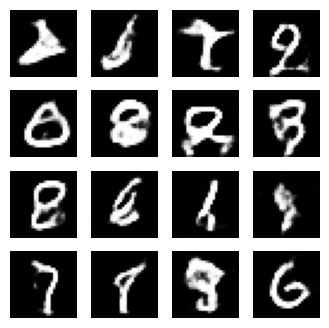

Time for epoch 31 is 117.91286087036133 sec


In [ ]:
train(x_train,epochs)